# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType


from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, desc
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring
from pyspark.sql.functions import sum as spark_sum, avg as spark_avg



import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Data Exploration") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '43099'),
 ('spark.driver.host',
  '5863f353be737fc38d9029e58da34b2002b1ee70-bdf88b46b-5n77r'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1700001506967'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'Sparkify Data Exploration'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [6]:
# printing out header
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# print out the first record
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

We will start exploring the data using SQL, so we need to create a temporary view.

In [8]:
user_log.createOrReplaceTempView("user_log_table")
spark.sql('DESC user_log_table\
          ').show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   null|
|         auth|   string|   null|
|    firstName|   string|   null|
|       gender|   string|   null|
|itemInSession|   bigint|   null|
|     lastName|   string|   null|
|       length|   double|   null|
|        level|   string|   null|
|     location|   string|   null|
|       method|   string|   null|
|         page|   string|   null|
| registration|   bigint|   null|
|    sessionId|   bigint|   null|
|         song|   string|   null|
|       status|   bigint|   null|
|           ts|   bigint|   null|
|    userAgent|   string|   null|
|       userId|   string|   null|
+-------------+---------+-------+



In [9]:
#checking unique values in auth
spark.sql('SELECT DISTINCT auth\
            FROM user_log_table\
            ').show()
#auth show the status of the user when they are using the platform
#NB: check the number of unique users using the platform as cancelled and see if it matched with churn users

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [10]:
#checking unique values in status
spark.sql('SELECT DISTINCT status\
            FROM user_log_table\
            ').show()


+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [11]:
#checking unique values in method
spark.sql('SELECT DISTINCT method\
            FROM user_log_table\
            ').show()


+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [12]:
spark.sql('SELECT DISTINCT page\
          FROM user_log_table').show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [13]:
#How many records does the dataset have?
spark.sql('SELECT COUNT(*) AS number_rows\
            FROM user_log_table').show()

+-----------+
|number_rows|
+-----------+
|     286500|
+-----------+



In [14]:
#How many distint users?
spark.sql('SELECT COUNT(DISTINCT userid) AS unique_users\
            FROM user_log_table\
            ').show()

+------------+
|unique_users|
+------------+
|         226|
+------------+



In this dataset there are 226 unique users

In [15]:
# how many paid and free users?
spark.sql('SELECT COUNT(DISTINCT userid) AS paid_free\
            FROM user_log_table\
            GROUP BY level').show()

+---------+
|paid_free|
+---------+
|      196|
|      166|
+---------+



This doesn't sum up so it means that at some point, some users went from paid to free, or vice versa

Let's take a look at page visits

In [16]:
spark.sql('SELECT page, COUNT(*) AS number_visits\
            FROM user_log_table\
            GROUP BY page\
            ORDER BY page').show()

+--------------------+-------------+
|                page|number_visits|
+--------------------+-------------+
|               About|          924|
|          Add Friend|         4277|
|     Add to Playlist|         6526|
|              Cancel|           52|
|Cancellation Conf...|           52|
|           Downgrade|         2055|
|               Error|          258|
|                Help|         1726|
|                Home|        14457|
|               Login|         3241|
|              Logout|         3226|
|            NextSong|       228108|
|            Register|           18|
|         Roll Advert|         3933|
|       Save Settings|          310|
|            Settings|         1514|
|    Submit Downgrade|           63|
| Submit Registration|            5|
|      Submit Upgrade|          159|
|         Thumbs Down|         2546|
+--------------------+-------------+
only showing top 20 rows



The churn column will be create using Cancellation Confirmation, which is the same number as Cancel. We can quickly check if the userId who went on cancel are the same as those who went to Cancellation confirmation

#### Feature documentation

The data includes the following columns:
- artist (string) : artist/singer name - keep
- auth (string): user status - keep and might be important 
- firstName (string) : user first name - do not keep
- gender (string): user's gender (female or male) - keep - can be changed to categorical
- itemInSession (long): number of events during the current session - keep
- lastName (string) : user's lastname - do not keep
- length (double): duration of song played - keep 
- level (string): subscription level (paid or free) - keep - can be changed to categorical.
- location (string): user's location format city, state (in the USA) - keep- can be engineered by separating state
- method (string): (put or get) - do not keep 
- page (string): page where the user is - keep
- registration (long): timestamp of when the user registered. - keep - change time format, and check if there is any data for guests.
- sessionId (long): unique Id for the session the user is in - explore before discarding
- song (string): song playing - keep
- status (long): looks like page error status
- ts (long): timestamp , must be time when the user started the session 
- userAgent ( string ) : browser keep and change to categorical
- userId ( string) unique Id per user - keep 

#### Features to drop
- firstname, lastname, method, 

In [17]:
cols = ("firstname","lastname","method")
user_log = user_log.drop(*cols)
user_log.printSchema()  

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [18]:
user_log.createOrReplaceTempView("user_log_table")
spark.sql('DESC user_log_table\
          ').show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   null|
|         auth|   string|   null|
|       gender|   string|   null|
|itemInSession|   bigint|   null|
|       length|   double|   null|
|        level|   string|   null|
|     location|   string|   null|
|         page|   string|   null|
| registration|   bigint|   null|
|    sessionId|   bigint|   null|
|         song|   string|   null|
|       status|   bigint|   null|
|           ts|   bigint|   null|
|    userAgent|   string|   null|
|       userId|   string|   null|
+-------------+---------+-------+



# Feature engineering
This will include:
- taking care of any time related features: ts and registration
- creating new features using time related features: registration month etc..
- identifying missing data and make a decision on these
- finalizing features selected and check their type (categorical binary etc.)

## Reformating time features into date

In [19]:
# these two columns have timestamps so they will be engineered to extract data on time (day, month, year)
spark.sql('SELECT ts, registration \
          FROM user_log_table\
          LIMIT 10 ').show()

+-------------+-------------+
|           ts| registration|
+-------------+-------------+
|1538352117000|1538173362000|
|1538352180000|1538331630000|
|1538352394000|1538173362000|
|1538352416000|1538331630000|
|1538352676000|1538173362000|
|1538352678000|1538331630000|
|1538352886000|1538331630000|
|1538352899000|1538173362000|
|1538352905000|1538173362000|
|1538353084000|1538173362000|
+-------------+-------------+



ts and registration are timestamps so we will convert into readable time

In [20]:
user_log = user_log.withColumn('ts_ts', (col('ts') / 1000.0).cast(TimestampType()))

In [21]:
user_log = user_log.withColumn('ts_todate', to_date('ts_ts'))

In [22]:
user_log = user_log.withColumn('registration_ts', (col('registration') / 1000.0).cast(TimestampType()))

In [23]:
user_log = user_log.withColumn('registration_todate', to_date('registration_ts'))

In [24]:
cols = ("ts","registration","ts_ts","registration_ts")
user_log = user_log.drop(*cols)

In [25]:
#recreate sql view
user_log.createOrReplaceTempView("user_log_table")
spark.sql('DESC user_log_table').show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|             artist|   string|   null|
|               auth|   string|   null|
|             gender|   string|   null|
|      itemInSession|   bigint|   null|
|             length|   double|   null|
|              level|   string|   null|
|           location|   string|   null|
|               page|   string|   null|
|          sessionId|   bigint|   null|
|               song|   string|   null|
|             status|   bigint|   null|
|          userAgent|   string|   null|
|             userId|   string|   null|
|          ts_todate|     date|   null|
|registration_todate|     date|   null|
+-------------------+---------+-------+



#### ts and registration were reformated and are now dates. Let's take a look

In [26]:
spark.sql('SELECT ts_todate, registration_todate\
           FROM user_log_table').show()

+----------+-------------------+
| ts_todate|registration_todate|
+----------+-------------------+
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-30|
|2018-10-01|         2018-09-19|
|2018-10-01|         2018-09-28|
|2018-10-01|         2018-09-30|
+----------+-------------------+
only showing top 20 rows



## Missing data and invalid data

In [27]:
### Missing or invalid data in userids or sessionid
spark.sql('SELECT * \
           FROM user_log_table \
           WHERE userId IS NULL \
            ').show()

+------+----+------+-------------+------+-----+--------+----+---------+----+------+---------+------+---------+-------------------+
|artist|auth|gender|itemInSession|length|level|location|page|sessionId|song|status|userAgent|userId|ts_todate|registration_todate|
+------+----+------+-------------+------+-----+--------+----+---------+----+------+---------+------+---------+-------------------+
+------+----+------+-------------+------+-----+--------+----+---------+----+------+---------+------+---------+-------------------+



In [28]:
spark.sql('SELECT * \
           FROM user_log_table \
           WHERE sessionId IS NULL \
            ').show()

+------+----+------+-------------+------+-----+--------+----+---------+----+------+---------+------+---------+-------------------+
|artist|auth|gender|itemInSession|length|level|location|page|sessionId|song|status|userAgent|userId|ts_todate|registration_todate|
+------+----+------+-------------+------+-----+--------+----+---------+----+------+---------+------+---------+-------------------+
+------+----+------+-------------+------+-----+--------+----+---------+----+------+---------+------+---------+-------------------+



There is no null values in userId or sessionId

In [29]:
spark.sql('SELECT DISTINCT userId \
           FROM user_log_table \
           ORDER BY userId \
            ').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [30]:
spark.sql('SELECT DISTINCT sessionId \
           FROM user_log_table \
           ORDER BY sessionId \
            ').show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [31]:
spark.sql('SELECT COUNT(userId) AS empty_strings_in_userid \
           FROM user_log_table \
           WHERE userId = "" \
            ').show()

+-----------------------+
|empty_strings_in_userid|
+-----------------------+
|                   8346|
+-----------------------+



There are userids that have empty strings. Who are these users?
Since we don't know if this is the same user or multiple users, we are going to remove all userid with empty strings. We know that in auth, there is a guest value, let's check if the empty string userid are those who are guest so they did not register to the platform.

In [32]:
spark.sql('SELECT DISTINCT auth\
           FROM user_log_table \
           WHERE userId = "" \
          ').show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



We see that both logged out and guests do not have a userId, so it makes sense to remove them, since we cannot associated them with any user.

In [33]:
#filtering out rows with '' for userId
condition = user_log.userId != ''
user_log_filtered = user_log.filter(condition)

In [34]:
#rebuild database view
user_log_filtered.createOrReplaceTempView("user_log_table_filtered")


In [35]:
spark.sql('SELECT COUNT(*) num_records_after_filtering\
           FROM user_log_table_filtered\
           ').show()

+---------------------------+
|num_records_after_filtering|
+---------------------------+
|                     278154|
+---------------------------+



In [36]:
spark.sql('SELECT COUNT(DISTINCT userId) AS userId_count\
           FROM user_log_table_filtered\
           ').show()

+------------+
|userId_count|
+------------+
|         225|
+------------+



We have 278154 remaining records and 225 users. (which makes sense since userid with empty strings counted as 1).

In [37]:
# what time interval are the records of this subset?
spark.sql('SELECT MIN(ts_todate), MAX(ts_todate)\
           FROM user_log_table_filtered\
          ').show()

+--------------+--------------+
|min(ts_todate)|max(ts_todate)|
+--------------+--------------+
|    2018-10-01|    2018-12-03|
+--------------+--------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [38]:
spark.sql('SELECT COUNT(DISTINCT userid)\
           FROM user_log_table_filtered\
           WHERE page = "Cancellation Confirmation"\
          ').show()

+----------------------+
|count(DISTINCT userid)|
+----------------------+
|                    52|
+----------------------+



In [39]:
52/225*100

23.11111111111111

In the small dataset has 52 churning users which makes 23% rate on this data set. Let's check over what timeframe the dataset includes sessions.

Let's use Cancellation Confirmation to create the churn label.

In [40]:
user_log_clean = user_log_filtered 

In [41]:
#function to create the churn label
create_churn = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())

user_log_clean = user_log_clean.withColumn('churn_lab', create_churn('page'))

In [42]:
user_log_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 10, 1), registration_todate=datetime.date(2018, 9, 28), churn_lab=0)]

Since we only defined churn binary coding based on 'page', and that the whole dataset is based on sessionid, we are going to have users that churned but with a 0 label for all the pages they have been to that are not cancellation confirmation.

Now let's replace all the 0 of churn users to 1.



In [43]:
# collect all the users with 1 for churn_lab
churn_userid = user_log_clean.select('userId').where(col('churn_lab')==1).groupby('userId').count()
churn_userid_list = [row['userId'] for row in churn_userid.collect()]
len(churn_userid_list)

52

In [44]:
user_log_clean = user_log_clean.withColumn('churn_lab2', when((user_log_clean.userId).isin(churn_userid_list), 1).otherwise(0))

In [45]:
user_log_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 10, 1), registration_todate=datetime.date(2018, 9, 28), churn_lab=0, churn_lab2=0)]

In [46]:
user_log_clean.createOrReplaceTempView("user_log_table_clean")


In [47]:
spark.sql('SELECT userId, churn_lab, churn_lab2\
           FROM user_log_table_clean \
           WHERE churn_lab2 = 1').show()

+------+---------+----------+
|userId|churn_lab|churn_lab2|
+------+---------+----------+
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|    54|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
|   101|        0|         1|
+------+---------+----------+
only showing top 20 rows



In [48]:

user_log_clean = user_log_clean.drop("churn_lab")
user_log_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 10, 1), registration_todate=datetime.date(2018, 9, 28), churn_lab2=0)]

### Function for churn labeling

In [49]:
# function for churn labeling
def create_churn_label(df):
    ''' This function takes a dataframe and creates churn labels based on the 
    churn definition: Cancellation Confirmation value in 'pages' is considered churn.
    
    Input = Spark dataframe
    
    Output = Spark dataframe with new column 'churn_lab' for each user who churned
    '''
    #labeling all 'pages' with Cancellation Confirmation
    create_churn = udf(lambda x: 1 if x =="Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn('churn_lab_temp', create_churn('page'))
    
    #extract a list of churn users from the new df
    churn_userid = df.select('userId').where(col('churn_lab_temp')==1).groupby('userId').count()
    churn_userid_list = [row['userId'] for row in churn_userid.collect()]
    
    #new column based on the churn list
    df = df.withColumn('churn_lab', when((user_log_clean.userId).isin(churn_userid_list), 1).otherwise(0))
    
    #dropping column
    df = df.drop('churn_lab_temp')
    
    return df   

In [50]:
#let's test the function on a copy of the dataframe
user_log_test = user_log_filtered

In [51]:
user_log_test_churn = create_churn_label(user_log_test)

In [52]:
user_log_test_churn.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 10, 1), registration_todate=datetime.date(2018, 9, 28), churn_lab=0)]

In [53]:
user_log_test_churn.select('churn_lab').groupby('churn_lab').count().show()

+---------+------+
|churn_lab| count|
+---------+------+
|        1| 44864|
|        0|233290|
+---------+------+






### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [54]:
#clean ddata sql view
user_log_clean.createOrReplaceTempView("user_log_table_clean")


In [55]:
spark.sql('DESC user_log_table_clean').show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|             artist|   string|   null|
|               auth|   string|   null|
|             gender|   string|   null|
|      itemInSession|   bigint|   null|
|             length|   double|   null|
|              level|   string|   null|
|           location|   string|   null|
|               page|   string|   null|
|          sessionId|   bigint|   null|
|               song|   string|   null|
|             status|   bigint|   null|
|          userAgent|   string|   null|
|             userId|   string|   null|
|          ts_todate|     date|   null|
|registration_todate|     date|   null|
|         churn_lab2|      int|   null|
+-------------------+---------+-------+



- Session count

In [56]:
# how many sessions did each userId create?
session_count_by_churn = user_log_clean.groupby('userId','churn_lab2').agg(count("*").alias("count")).toPandas()

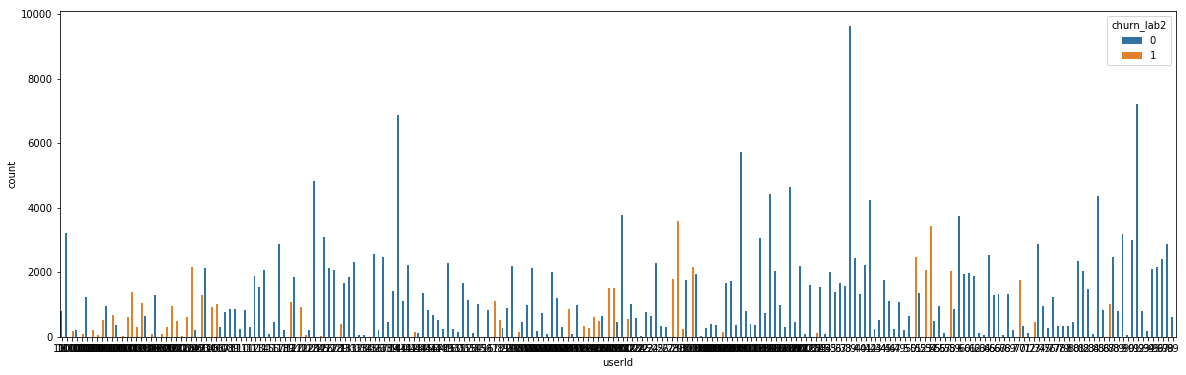

In [57]:
#plot of session count for each user.
plt.figure(figsize=(20, 6))
sns.barplot(data=session_count_by_churn, x='userId', y='count', hue='churn_lab2')


- artist

In [58]:
artist_by_churn = user_log_clean.groupby('artist','churn_lab2').agg(count("*").alias("count")).toPandas().sort_values(by=['count'], ascending = False)

In [59]:
artist_by_churn.head()

,artist,churn_lab2,count
23847,None,0,41576
5385,None,1,8470
18309,Coldplay,0,1552
21567,Kings Of Leon,0,1542
13150,Florence + The Machine,0,1048


We see that the most played artist is coldplay with no churn, and over 40000 sessions did not play any songs

- 'auth'

In [60]:
user_log_clean.select('auth').groupby('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



Either I remove this feature or I can explore it later with when the loggin happened.

- gender

In [61]:
# take all users, churn and gender, drop duplicate rows by users, 
gender_by_churn = user_log_clean.dropDuplicates(['userId']).groupBy('gender','churn_lab2').agg(count('*').alias('user_count')).toPandas()
gender_by_churn.head()

,gender,churn_lab2,user_count
0,M,1,32
1,F,0,84
2,F,1,20
3,M,0,89


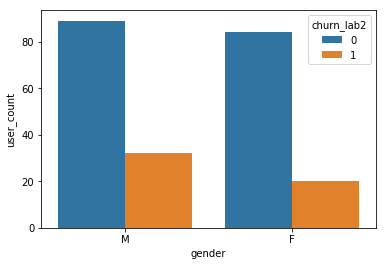

In [62]:
sns.barplot(data=gender_by_churn, x='gender', y='user_count', hue='churn_lab2')

- length

In [63]:
user_log_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_todate=datetime.date(2018, 10, 1), registration_todate=datetime.date(2018, 9, 28), churn_lab2=0)]

In [64]:
# look at the average session length per user and churning
columns = ['userId','length','churn_lab2']
user_log_clean_length_df = user_log_clean.select(columns)

In [65]:
length_agg_df = user_log_clean_length_df.groupBy("userId", "churn_lab2").agg(
                spark_sum("length").alias("total_session_length"),
                spark_avg("length").alias("avg_session_length"))


In [68]:
length_agg_df.take(10)

[Row(userId='19', churn_lab2=0, total_session_length=54480.933869999986, avg_session_length=252.22654569444438),
 Row(userId='100005', churn_lab2=1, total_session_length=37037.12201000001, avg_session_length=240.50079227272732),
 Row(userId='200007', churn_lab2=0, total_session_length=15739.869310000002, avg_session_length=242.15183553846157),
 Row(userId='300007', churn_lab2=1, total_session_length=28028.71048000002, avg_session_length=252.5109052252254),
 Row(userId='50', churn_lab2=0, total_session_length=122751.27560999998, avg_session_length=244.03832129224648),
 Row(userId='200002', churn_lab2=0, total_session_length=94008.87593999997, avg_session_length=242.91699209302317),
 Row(userId='30', churn_lab2=0, total_session_length=359808.2456400001, avg_session_length=253.92254455892737),
 Row(userId='8', churn_lab2=0, total_session_length=63393.53190999998, avg_session_length=252.56387215139435),
 Row(userId='100011', churn_lab2=1, total_session_length=2841.6995, avg_session_length=

In [70]:
length_agg_pd = length_agg_df.toPandas()


In [76]:
length_agg_pd.head()

,userId,churn_lab2,total_session_length,avg_session_length
0,19,0,54480.93387,252.226546
1,100005,1,37037.12201,240.500792
2,200007,0,15739.86931,242.151836
3,300007,1,28028.71048,252.510905
4,50,0,122751.27561,244.038321


<Container object of 225 artists>

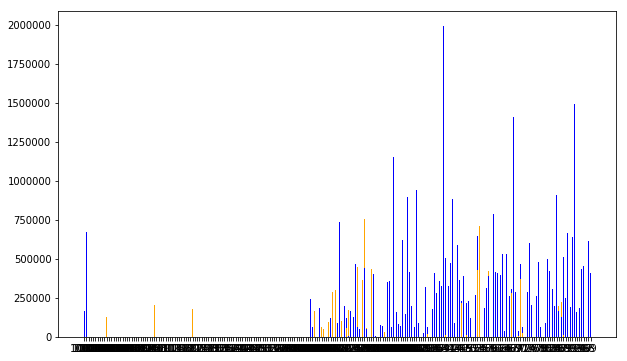

In [79]:
#plot aggregates


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(
    length_agg_pd["userId"],
    length_agg_pd["total_session_length"],
    width=0.4,
    color=length_agg_pd["churn_lab2"].map({0: 'blue', 1: 'orange'}),
    label='Total Session Length'
)



<Container object of 225 artists>

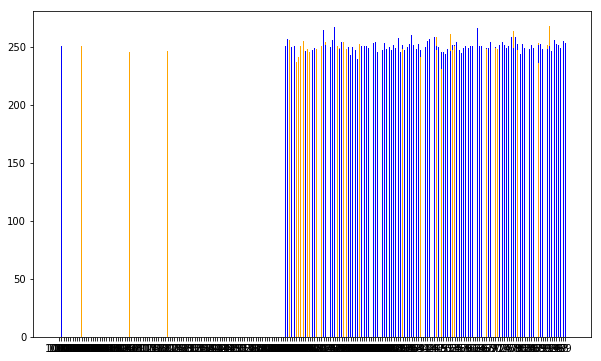

In [80]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(
    length_agg_pd["userId"],
    length_agg_pd["avg_session_length"],
    width=0.4,
    color=length_agg_pd["churn_lab2"].map({0: 'blue', 1: 'orange'}),
    label='Average Session Length'
)



level

In [ ]:
user_log_clean.select('level').groupby('level').count().show()

location

In [ ]:
user_log_clean.dropDuplicates(['userId']).select('location').groupby('location').count().show()

page

song

status

userAgent

In [ ]:
user_log_clean.take(1)

ts_todate

registration_todate

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
#let's take a look at the schema again


- select features to keep
- define what features need to be engineered and what to do
-- timestamp

#create udf functions using lambda
function_name = udf(lambda x: action(, x), IntegerType())

#to create new columns
df.withColumn("newcolname",function(df.oldcolname))

In [ ]:
user_log_clean.take(1)

In [ ]:
def prepare_data(df):
    '''This function takes a the spark dataframe and executes the following main steps:
    - checking and removing missing data in userId
    - drops all features that won't be used in the model
    - churn labeling
    - reformat timestamp to dates
    - from here, aggregation by userid
    - create new features: avg_song_length, avg_session_length, duration_registered, session_count, count_by_page_type
    - 
    
    Input: spark dataframe
    Output: clean spark dataframe including one row per userId and new features'''
    
    #feature drop
    
    #missing data
    
    #churn labeling
    #use function created earlier
    
    
    
    #new features and aggregation by feature
    #allows to aggregate many features in one step
  #  agg_df = spark_df.groupBy("User_ID").agg(
  #                            mean("Feature1").alias("Avg_Feature1"),
  #                            sum("Feature1").alias("Sum_Feature1"),
  #                            max("Feature2").alias("Max_Feature2"),
   #                           first("gender").alias("gender"),
   #                           first("userAgent").alias("userAgent"),
    #                          first("location").alias("location"),
    #                          spark_sum("length").alias("total_session_length"),
    #                          spark_avg("length").alias("avg_session_length"),
    #                          first("churn_lab").alias("churn_label"))

   
    
    
    
    
    return clean_df

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
# splitting data
train, test = df.randomSplit(weights=[0.8,0.2], seed=200)


In [ ]:
# give the model accuracy
lr.Model2.summary.accuracy

In [ ]:
#pipeline - create a variable for each model and then use the function Pipeline


model1 =
model2 = 

pipeline = Pipeline(stages=[model,model2])


In [ ]:
plrModel = pipeline.fit(train) #trains the model

In [ ]:
test_predictions = plrModel.transform(test) #predicts

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.